In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

In [2]:
digits_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
digits_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
digit_values = digits_train.data/255.
digit_labels = digits_train.targets

In [4]:
digit_values.shape

torch.Size([60000, 28, 28])

In [5]:
# onehot-encode labels
digit_labels_onehot = np.zeros((len(digit_labels), 10))
digit_labels_onehot[np.arange(len(digit_labels)), digit_labels] = 1

In [6]:
digit_labels_onehot.shape

(60000, 10)

In [13]:
class DigitEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )

    def forward(self, x):
        return self.encoder(x)

In [14]:
class LabelEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 32)
        )

    def forward(self, x):
        return self.encoder(x)

In [15]:
class BasicCLIP(nn.Module):
    def __init__(self):
        super().__init__()

        self.image_encoder = DigitEncoder()
        self.label_encoder = LabelEncoder()
        self.temperature = nn.Parameter(torch.tensor(np.log(1/0.07)))

        self.W_i = nn.Linear(32, 128)
        self.W_t = nn.Linear(32, 128)

    def forward(self, imgs, labels):
        I_f = self.image_encoder(imgs)
        T_f = self.label_encoder(labels)

        I_e = self.W_i(I_f)
        T_e = self.W_t(T_f)

        # l2 normalize
        I_e = torch.nn.functional.normalize(I_e, p=2, dim=1)
        T_e = torch.nn.functional.normalize(T_e, p=2, dim=1)


        logits = I_e @ T_e.T * self.temperature

        return logits

In [16]:
def loss_function(logits, N):
    loss_i = nn.functional.cross_entropy(logits, torch.arange(N))
    loss_t = nn.functional.cross_entropy(logits.T, torch.arange(N))

    loss = (loss_i + loss_t)/2

    return loss


In [17]:
BATCH_SIZE = 32
clip = BasicCLIP()
optimizer = optim.Adam(clip.parameters(), lr=0.001)

for epoch in range(10):
    for i in range(0, len(digit_values), BATCH_SIZE):
        optimizer.zero_grad()

        logits = clip(
            digit_values[i:i+BATCH_SIZE].view(-1, 784).float(),
            torch.tensor(digit_labels_onehot[i:i+BATCH_SIZE]).float()
        )

        loss = loss_function(logits, logits.shape[0])
        loss.backward()
        optimizer.step()

    if i % 1 == 0:
        print(f'Epoch {epoch} Iteration {i} Loss: {loss.item()}')

Epoch 0 Iteration 59968 Loss: 1.3736095428466797
Epoch 1 Iteration 59968 Loss: 1.3150941133499146
Epoch 2 Iteration 59968 Loss: 1.3512327671051025
Epoch 3 Iteration 59968 Loss: 1.2741365432739258
Epoch 4 Iteration 59968 Loss: 1.2668113708496094


KeyboardInterrupt: 

In [29]:
# save only label encoder
torch.save(clip.label_encoder.state_dict(), 'label_encoder.pth')

In [18]:
test_digit_values = digits_test.data/255.
test_digit_labels = digits_test.targets

# onehot
# onehot-encode labels
test_digit_labels_onehot = np.zeros((len(test_digit_labels), 10))
test_digit_labels_onehot[np.arange(len(test_digit_labels)), test_digit_labels] = 1

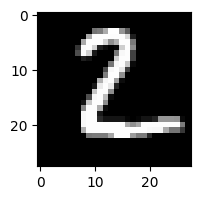

In [19]:
import matplotlib.pyplot as plt

sample_image = test_digit_values[1]
plt.figure(figsize=(2,2))
plt.imshow(sample_image, cmap='gray')

In [20]:
from tqdm import tqdm

test_labels_array = torch.tensor(np.arange(0,10,1))
test_labels_onehot = np.zeros((10, 10))
test_labels_onehot[np.arange(10), test_labels_array] = 1

# run through all testing examples
predictions = []
for image in tqdm(test_digit_values):
    output = clip(image.view(-1,784).float(), torch.tensor(test_labels_onehot).float())
    probs = torch.nn.functional.softmax(output, dim=1)
    # get max
    prediction = torch.argmax(probs.detach())
    predictions.append(prediction)

100%|██████████| 10000/10000 [00:13<00:00, 724.63it/s]


In [21]:
predictions = np.array(predictions)
real = test_digit_labels.numpy()
(predictions == real).sum() / len(real)

0.9772

In [22]:

output = clip(sample_image.view(-1,784).float(), torch.tensor(test_labels_onehot).float())
probs = torch.nn.functional.softmax(output, dim=1)

In [23]:
probs

tensor([[1.2723e-03, 3.6224e-04, 9.9121e-01, 2.7279e-03, 8.0714e-04, 7.9923e-04,
         4.7820e-04, 8.5915e-04, 1.0214e-03, 4.6335e-04]],
       grad_fn=<SoftmaxBackward0>)

<BarContainer object of 10 artists>

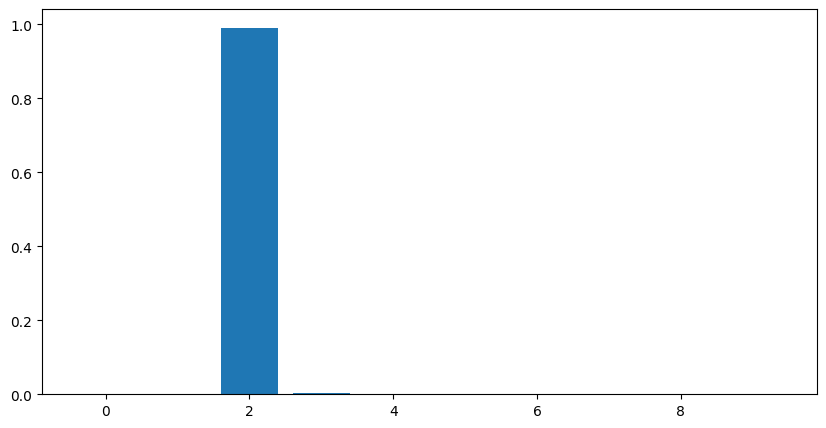

In [24]:
# plot barchart
plt.figure(figsize=(10,5))
plt.bar(np.arange(10), probs[0].detach().numpy())

In [25]:
test_labels_onehot.shape

(10, 10)

/tmp/ipykernel_19841/3213019137.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = clip(torch.tensor(sample).float(), torch.tensor(test_labels_onehot).float())


Text(50.722222222222214, 0.5, 'image #')

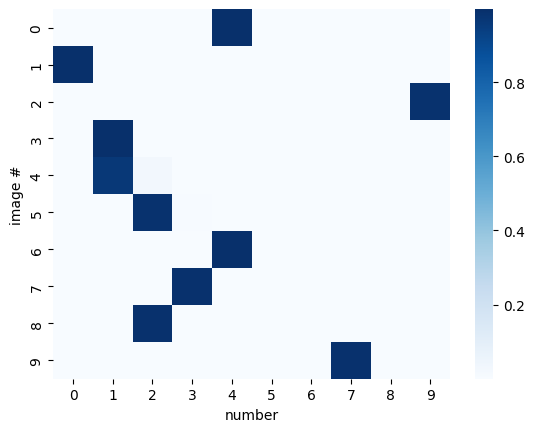

In [26]:
# sample of 10 images
sample = digit_values[20:30].view(10, -1)


logits = clip(torch.tensor(sample).float(), torch.tensor(test_labels_onehot).float())

probs = nn.functional.softmax(logits, dim=1)
# heatmap
import seaborn as sns

sns.heatmap(probs.detach().numpy(), cmap='Blues', annot=False, xticklabels=test_labels_array.numpy(), yticklabels=np.arange(10))
plt.xlabel("number")
plt.ylabel("image #")
# yaxis is image
# xaxis is number

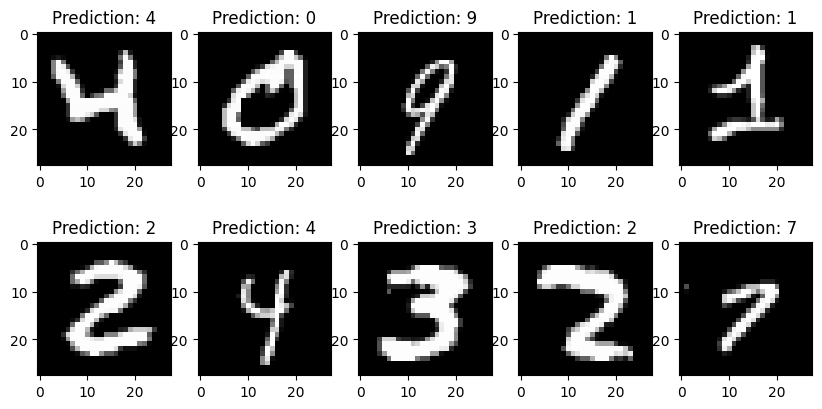

In [27]:
# plot sample images
plt.figure(figsize=(10,5))
plt.tight_layout()
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(sample[i].view(28,28), cmap='gray')
    plt.title(f'Prediction: {torch.argmax(probs[i])}')

In [49]:
# send the test digits through the encoder and get latent representations
encoder = clip.image_encoder
latent = encoder(test_digit_values.view(-1, 784).float())

In [50]:
latent.shape

torch.Size([10000, 32])

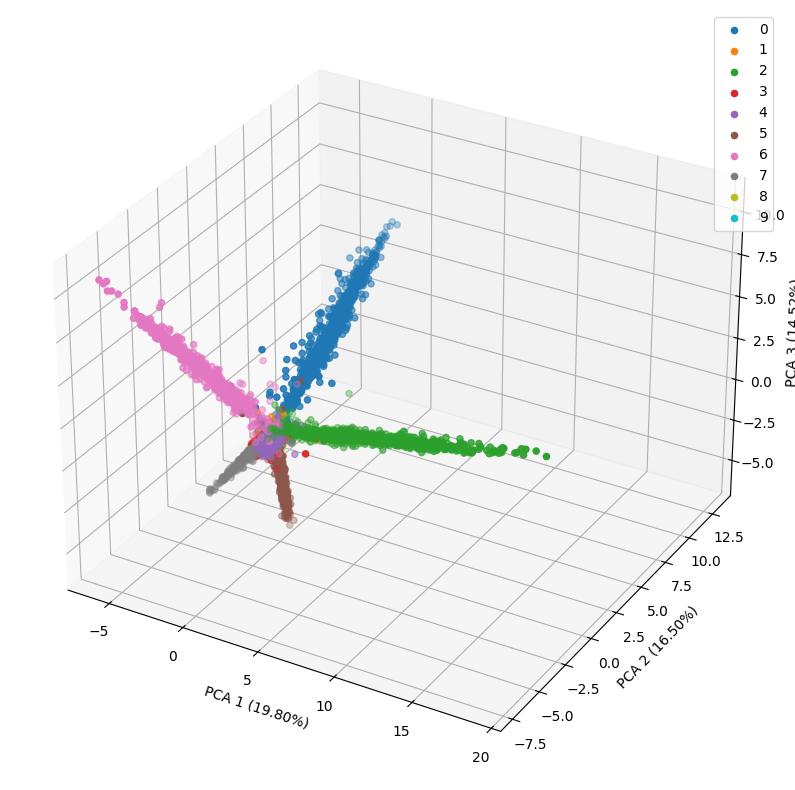

In [56]:
# pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler().fit_transform(latent.detach().numpy())
pca = PCA(n_components=3)

pca_latent = pca.fit_transform(scaled)

# plot 3d according to label color include legend
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(10):
    ax.scatter(pca_latent[real == i, 0], pca_latent[real == i, 1], pca_latent[real == i, 2], label=i)

ax.set_xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
ax.set_ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
ax.set_zlabel(f"PCA 3 ({pca.explained_variance_ratio_[2]*100:.2f}%)")
ax.legend()
plt.show()